In [1]:
import pandas as pd

bbbp_df = pd.read_csv("data/BBBP.csv")

# Preview the dataset
print(bbbp_df.shape)
print(bbbp_df.head())

(2050, 4)
   num                  name  p_np  \
0    1            Propanolol     1   
1    2  Terbutylchlorambucil     1   
2    3                 40730     1   
3    4                    24     1   
4    5           cloxacillin     1   

                                              smiles  
0                   [Cl].CC(C)NCC(O)COc1cccc2ccccc12  
1           C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl  
2  c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...  
3                   C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C  
4  Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...  


In [2]:
# Cleaning data
bbbp_df = bbbp_df[['smiles', 'p_np']].dropna()
bbbp_df.head()

,smiles,p_np
0,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,1
1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,1
2,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,1
3,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,1
4,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,1


In [14]:
from rdkit import Chem

bbbp_df["valid"] = 0

for i, row in bbbp_df.iterrows():
    smiles = row["smiles"]
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        bbbp_df.loc[i, "valid"] = 0
    else:
        bbbp_df.loc[i,"valid"] = 1

[15:51:23] Explicit valence for atom # 1 N, 4, is greater than permitted
[15:51:23] WARNING: not removing hydrogen atom without neighbors
[15:51:23] Explicit valence for atom # 6 N, 4, is greater than permitted
[15:51:23] WARNING: not removing hydrogen atom without neighbors
[15:51:23] WARNING: not removing hydrogen atom without neighbors
[15:51:23] WARNING: not removing hydrogen atom without neighbors
[15:51:23] WARNING: not removing hydrogen atom without neighbors
[15:51:23] WARNING: not removing hydrogen atom without neighbors
[15:51:23] WARNING: not removing hydrogen atom without neighbors
[15:51:23] Explicit valence for atom # 6 N, 4, is greater than permitted
[15:51:23] WARNING: not removing hydrogen atom without neighbors
[15:51:23] WARNING: not removing hydrogen atom without neighbors
[15:51:23] WARNING: not removing hydrogen atom without neighbors
[15:51:23] WARNING: not removing hydrogen atom without neighbors
[15:51:23] Explicit valence for atom # 11 N, 4, is greater than pe

In [16]:
print(sum(bbbp_df["valid"]))
print(len(bbbp_df))

2039
2050


In [17]:
bbbp_df = bbbp_df[bbbp_df.valid == 1]


In [18]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import numpy as np
from tqdm import tqdm

def mol_to_fp(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    generator = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=nBits)
    fp = generator.GetFingerprintAsNumPy(mol)
    return fp

# Convert all molecules to fingerprints
fps = []
labels = []

for i, row in tqdm(bbbp_df.iterrows(), total=len(bbbp_df)):
    fp = mol_to_fp(row['smiles'])
    if fp is not None:
        fps.append(fp)
        labels.append(row['p_np'])

X = np.array(fps)
y = np.array(labels)


  0%|          | 0/2039 [00:00<?, ?it/s][15:53:48] WARNING: not removing hydrogen atom without neighbors
[15:53:48] WARNING: not removing hydrogen atom without neighbors
[15:53:48] WARNING: not removing hydrogen atom without neighbors
[15:53:48] WARNING: not removing hydrogen atom without neighbors
 12%|█▏        | 251/2039 [00:00<00:00, 2502.98it/s][15:53:48] WARNING: not removing hydrogen atom without neighbors
[15:53:48] WARNING: not removing hydrogen atom without neighbors
[15:53:48] WARNING: not removing hydrogen atom without neighbors
[15:53:48] WARNING: not removing hydrogen atom without neighbors
[15:53:48] WARNING: not removing hydrogen atom without neighbors
[15:53:48] WARNING: not removing hydrogen atom without neighbors
 29%|██▉       | 592/2039 [00:00<00:00, 2804.52it/s][15:53:48] WARNING: not removing hydrogen atom without neighbors
[15:53:48] WARNING: not removing hydrogen atom without neighbors
[15:53:48] WARNING: not removing hydrogen atom without neighbors
[15:53:48] 

In [19]:
X.shape

(2039, 2048)

In [20]:
y.shape

(2039,)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify if classification
)

In [22]:
import torch

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # For regression or binary classification

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class BBBP_NN(nn.Module):
    def __init__(self, input_size):
        super(BBBP_NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)  # Single output for binary classification
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.sigmoid(x)  # Sigmoid for binary classification


In [24]:
model = BBBP_NN(input_size=X_train.shape[1])
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [26]:
num_epochs = 100
batch_size = 64

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")


Epoch 1/100, Loss: 0.0188
Epoch 2/100, Loss: 0.0169
Epoch 3/100, Loss: 0.0204
Epoch 4/100, Loss: 0.0189
Epoch 5/100, Loss: 0.0161
Epoch 6/100, Loss: 0.0172
Epoch 7/100, Loss: 0.0151
Epoch 8/100, Loss: 0.0167
Epoch 9/100, Loss: 0.0144
Epoch 10/100, Loss: 0.0139
Epoch 11/100, Loss: 0.0157
Epoch 12/100, Loss: 0.0172
Epoch 13/100, Loss: 0.0143
Epoch 14/100, Loss: 0.0147
Epoch 15/100, Loss: 0.0161
Epoch 16/100, Loss: 0.0151
Epoch 17/100, Loss: 0.0132
Epoch 18/100, Loss: 0.0141
Epoch 19/100, Loss: 0.0172
Epoch 20/100, Loss: 0.0147
Epoch 21/100, Loss: 0.0131
Epoch 22/100, Loss: 0.0157
Epoch 23/100, Loss: 0.0131
Epoch 24/100, Loss: 0.0164
Epoch 25/100, Loss: 0.0158
Epoch 26/100, Loss: 0.0120
Epoch 27/100, Loss: 0.0161
Epoch 28/100, Loss: 0.0161
Epoch 29/100, Loss: 0.0166
Epoch 30/100, Loss: 0.0157
Epoch 31/100, Loss: 0.0152
Epoch 32/100, Loss: 0.0143
Epoch 33/100, Loss: 0.0167
Epoch 34/100, Loss: 0.0132
Epoch 35/100, Loss: 0.0127
Epoch 36/100, Loss: 0.0136
Epoch 37/100, Loss: 0.0159
Epoch 38/1

In [27]:
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor)
    y_pred = (y_pred_prob > 0.5).float()
    
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

acc = accuracy_score(y_test, y_pred.numpy())
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred.numpy(), average="binary")

print(f"Test Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Test Accuracy: 0.8873
Precision: 0.8982, Recall: 0.9615, F1-score: 0.9288


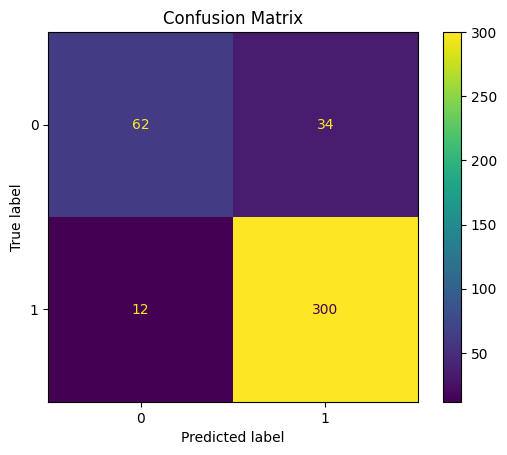

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# y_test and y_pred are numpy arrays or lists of 0/1 labels
cm = confusion_matrix(y_test, y_pred.numpy())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

plt.title("Confusion Matrix")
plt.show()